Run PCA on different model neural population trajectories generated by natural song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

PCA_FILE = 'data/simple/mlv_c/neur_basic/c_baker_dyn_pca/pca_results.npy'
DYN_FIT_FILE = 'data'

In [2]:
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

In [3]:
# nonlinear adaptive simulation
def smlt_dyn(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [4]:
pca_results = np.load(PCA_FILE, allow_pickle=True)[0]
pcs = pca_results['pcs']

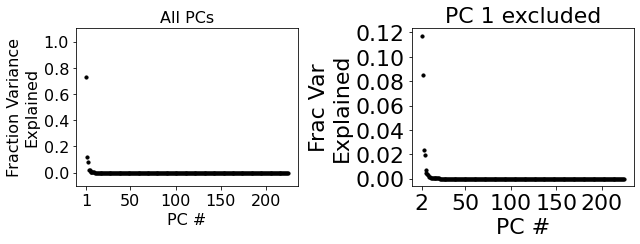

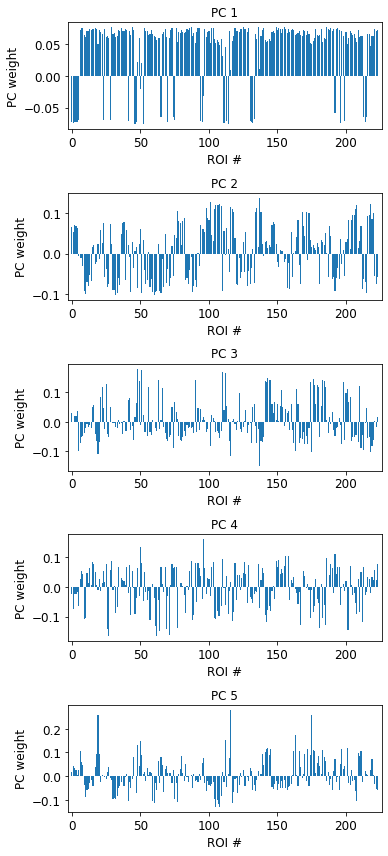

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5), tight_layout=True)

axs[0].scatter(1 + np.arange(NR), pca_results['expl_var'], c='k', s=10)
set_plot(axs[0], x_ticks=[1, 50, 100, 150, 200], y_lim=[-.1, 1.1], x_label='PC #', y_label='Fraction Variance\nExplained', title='All PCs', font_size=16)

axs[1].scatter(2 + np.arange(NR-1), pca_results['expl_var'][1:], c='k', s=10)
set_plot(axs[1], x_ticks=[2, 50, 100, 150, 200], x_label='PC #', y_label='Frac Var\nExplained', title='PC 1 excluded', font_size=22)

fig, axs = plt.subplots(5, 1, figsize=(5.5, 12), tight_layout=True)
for cpc, (pc, ax) in enumerate(zip(pcs, axs)):
    ax.bar(range(NR), pc)
    set_plot(ax, x_lim=[-3, NR+2], x_label='ROI #', y_label='PC weight', title=f'PC {cpc+1}', font_size=12)

PCs required for explained neural variance vs PCs required for explained behavioral variance

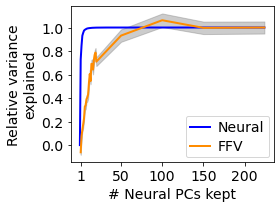

In [6]:
TARG = 'FFV'

npcs = []
r2_test_mns = []
r2_test_ses = []

for npc in 1+np.arange(NR):
    try:
        r2_tests = np.load(f'data/simple/mlv_c/neur_basic/c_baker_dyn_pca_zscored_npc_{npc}_{TARG.lower()}_276_tr.npy', allow_pickle=True)[0]['r2_test']
    except FileNotFoundError:
        continue
        
    r2_test_mns.append(r2_tests.mean())
    r2_test_ses.append(r2_tests.std()/np.sqrt(len(r2_tests)))

    npcs.append(npc)
    
r2_test_mns = np.array(r2_test_mns)
r2_test_ses = np.array(r2_test_ses)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(range(NR+1), cc([[0], pca_results['expl_var'].cumsum()]), lw=2, c='b')

ax.plot(npcs, r2_test_mns/r2_test_mns[-1], lw=2, c='darkorange')
ax.fill_between(npcs, (r2_test_mns - r2_test_ses)/r2_test_mns[-1], (r2_test_mns + r2_test_ses)/r2_test_mns[-1], color='gray', alpha=.4)
ax.legend(['Neural', 'FFV'])
set_plot(ax, x_ticks=[1, 50, 100, 150, 200], x_label='# Neural PCs kept', y_label='Relative variance\nexplained', font_size=14)

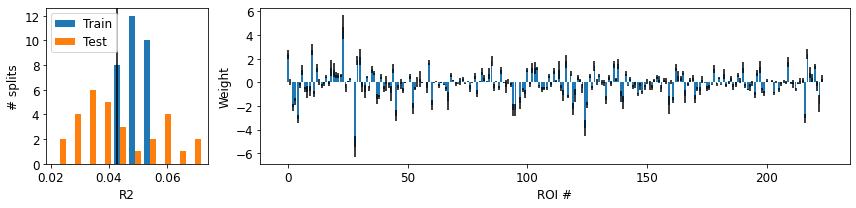

In [7]:
# mean regressor from lin fit from dyn neurons
DYN_FFV_FIT_FILE = 'data/simple/mlv_c/neur_basic/c_baker_ridge_0.1_dyn_all_ffv_276_tr.npy'
# DYN_FFV_FIT_FILE = 'data/simple/mlv/p_baker_dyn_all_ffv_276_tr.npy'
dyn_fit_data = np.load(DYN_FFV_FIT_FILE, allow_pickle=True)[0]

r2_train = dyn_fit_data['r2_train']
r2_test = dyn_fit_data['r2_test']

w_mn = dyn_fit_data['w'].mean(axis=0)
w_sd = dyn_fit_data['w'].std(axis=0)

gs = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(12, 3), tight_layout=True)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1:])]
axs[0].hist(np.array([r2_train, r2_test]).T)
axs[0].legend(['Train', 'Test'])
axs[0].axvline(r2_test.mean(), c='k')
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=12)

axs[1].bar(range(NR), w_mn, yerr=w_sd)
set_plot(axs[1], x_label='ROI #', y_label='Weight', font_size=12)

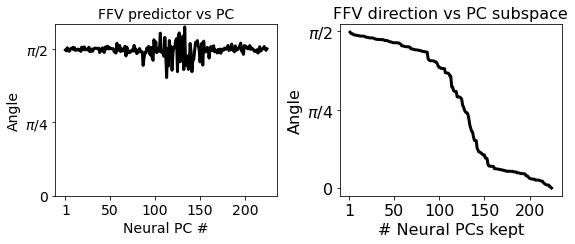

In [8]:
# w_mn = np.random.randn(NR)
w_mn_normed = w_mn/np.linalg.norm(w_mn)

# angle between FFV weight vector and nth PC
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)
axs[0].plot(1 + np.arange(NR), np.arccos(pcs@w_mn_normed), c='k', lw=3)
set_plot(axs[0], x_ticks=[1, 50, 100, 150, 200], y_ticks=[0, np.pi/4, np.pi/2], y_tick_labels=['0', r'$\pi/4$', r'$\pi/2$'], x_label='Neural PC #', y_label='Angle', title='FFV predictor vs PC', font_size=14)

# angle between FFV weight vector and subspace spanned by top n PCs 
angles = np.nan * np.zeros(NR)
for cpc in range(NR):
    # projection of weight vector onto subspace
    prj = pcs[:cpc, :].T @ (pcs[:cpc, :] @ w_mn_normed)
    prj = prj / np.linalg.norm(prj)
    
    angles[cpc] = np.arccos(prj@w_mn_normed)

axs[1].plot(1 + np.arange(NR), angles, c='k', lw=3)
set_plot(axs[1], x_ticks=[1, 50, 100, 150, 200], y_ticks=[0, np.pi/4, np.pi/2], y_tick_labels=['0', r'$\pi/4$', r'$\pi/2$'], x_label='# Neural PCs kept', y_label='Angle', title='FFV direction vs PC subspace', font_size=16)